## Download the data

In [ ]:
!mkdir Dataset
!wget  https://zenodo.org/records/7189381/files/trainX.npy?download=1  -O Dataset/Xdata.npy
!wget  https://zenodo.org/records/7189381/files/trainY.npy?download=1  -O Dataset/Ydata.npy

## Prepare paths of input images and target segmentation masks

In [19]:
import numpy as np #numpy numerical python
import tensorflow as tf # tensorflow it is mostly used for deep learning tensor manipulation
import keras # backend of tensorflow
import matplotlib.pyplot as plt # plotting
from sklearn.model_selection import train_test_split # split the dtaset into training and test
import sklearn # Accuracy assessment, 
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential

In [6]:
Xdata = np.load("Dataset/Xdata.npy")
Ydata = np.load("Dataset/Ydata.npy")
print(f"the shape of input image matrix is {Xdata.shape}")

the shape of input image matrix is (1119, 128, 128, 4)


## What does one input image and corresponding segmentation mask look like?

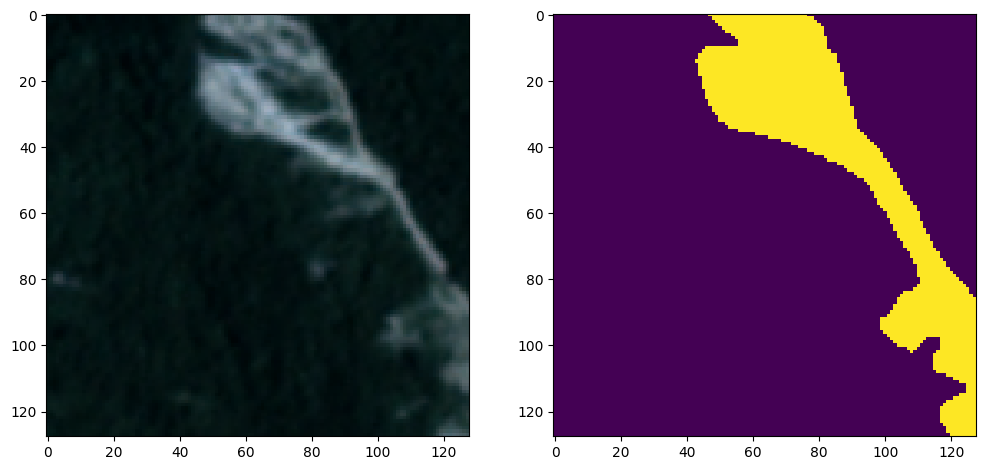

In [17]:
n = 289  # sample number
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) # making a subplot of 1 row 2 columns
ax[0].imshow(Xdata[n, :, :, :3].transpose((0, 1, 2))) #satellite image
ax[1].imshow(Ydata[n, :, :, 0]) #Ground Truth

ax[0].ticklabel_format(useOffset=False, style="plain")
ax[1].ticklabel_format(useOffset=False, style="plain")

## Prepare dataset to train validate and test the model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    Xdata, Ydata, test_size=0.3, random_state=42
)

## Prepare U-Net model

In [20]:
def down_block(x, filters, use_maxpool=True): # Function for down block 
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    if use_maxpool == True:
        return MaxPooling2D(strides=(2, 2))(x), x
    else:
        return x


def up_block(x, y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis=3)([x, y])
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # in the second convolution layer in decoder we do not
    #  need to upsample or concatenate because it has been done already
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # No max pooling because we do not need to decrease the size

    return x


def get_model(input_size=(128, 128, 4), *, classes, dropout):
    filter = [64, 128, 256, 512, 1024]
    # encode
    input = Input(shape=input_size)
    x, temp1 = down_block(input, filter[0]) #Calling the function
    x, temp2 = down_block(x, filter[1])
    x, temp3 = down_block(x, filter[2])
    x, temp4 = down_block(x, filter[3])
    x = down_block(x, filter[4], use_maxpool=False)
    # decode
    x = up_block(x, temp4, filter[3])
    x = up_block(x, temp3, filter[2])
    x = up_block(x, temp2, filter[1])
    x = up_block(x, temp1, filter[0])
    x = Dropout(dropout)(x)

    output = Conv2D(classes, 1, activation="sigmoid")(x)

    
    model = models.Model(input, output, name="unet")
    model.summary()
    return model


# Build model
model = get_model(input_size=(128, 128, 4), classes=1, dropout=0.2)
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         2368      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)         0         ['batch_normalization[0][0]

## Train the model

In [ ]:
# Compile model for training
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)


def trainmodel(model, xdata, ydata):
    NUMBER_EPOCHS = 20
    filepath = "checkpointMaping.keras"
    BATCH_SIZE = 32

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch"
    )
    print(type(xdata), type(ydata))
    hist = model.fit(
        x=xdata,
        y=ydata,
        epochs=NUMBER_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # auto validate using 20% of random samples at each epoch
        verbose=1,
        callbacks=[model_checkpoint_callback],
        
    )
    return hist

In [39]:
trainmodel(
    model,
    np.array(X_train, dtype=np.float32),
    np.expand_dims(np.array(y_train, dtype=np.float32), axis=-1),
)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.9137 - auc: 0.9733 - mean_io_u: 0.4875 - precision: 0.5484 - recall: 0.9241INFO:tensorflow:Assets written to: checkpointMaping/assets


INFO:tensorflow:Assets written to: checkpointMaping/assets


20/20 [==============================] - 9s 478ms/step - loss: 0.3335 - accuracy: 0.9137 - auc: 0.9733 - mean_io_u: 0.4875 - precision: 0.5484 - recall: 0.9241 - val_loss: 0.2471 - val_accuracy: 0.9164 - val_auc: 0.8853 - val_mean_io_u: 0.4531 - val_precision: 0.7046 - val_recall: 0.4023
Epoch 2/20
20/20 [==============================] - 4s 202ms/step - loss: 0.3281 - accuracy: 0.9233 - auc: 0.9738 - mean_io_u: 0.4934 - precision: 0.5818 - recall: 0.9119 - val_loss: 0.2591 - val_accuracy: 0.9217 - val_auc: 0.9133 - val_mean_io_u: 0.4627 - val_precision: 0.6457 - val_recall: 0.6245
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.9203 - auc: 0.9749 - mean_io_u: 0.4923 - precision: 0.5701 - recall: 0.9220INFO:tensorflow:Assets written to: checkpointMaping/assets


INFO:tensorflow:Assets written to: checkpointMaping/assets


20/20 [==============================] - 9s 465ms/step - loss: 0.3237 - accuracy: 0.9203 - auc: 0.9749 - mean_io_u: 0.4923 - precision: 0.5701 - recall: 0.9220 - val_loss: 0.2328 - val_accuracy: 0.9255 - val_auc: 0.9012 - val_mean_io_u: 0.4460 - val_precision: 0.7188 - val_recall: 0.5202
Epoch 4/20
20/20 [==============================] - 4s 202ms/step - loss: 0.3105 - accuracy: 0.9278 - auc: 0.9762 - mean_io_u: 0.4970 - precision: 0.5980 - recall: 0.9139 - val_loss: 0.2468 - val_accuracy: 0.9198 - val_auc: 0.9342 - val_mean_io_u: 0.4560 - val_precision: 0.6322 - val_recall: 0.6334
Epoch 5/20
20/20 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.9232 - auc: 0.9773 - mean_io_u: 0.4991 - precision: 0.5799 - recall: 0.9259INFO:tensorflow:Assets written to: checkpointMaping/assets


INFO:tensorflow:Assets written to: checkpointMaping/assets


20/20 [==============================] - 9s 457ms/step - loss: 0.3064 - accuracy: 0.9232 - auc: 0.9773 - mean_io_u: 0.4991 - precision: 0.5799 - recall: 0.9259 - val_loss: 0.2323 - val_accuracy: 0.9314 - val_auc: 0.9436 - val_mean_io_u: 0.4619 - val_precision: 0.6753 - val_recall: 0.7143
Epoch 6/20
20/20 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.9283 - auc: 0.9779 - mean_io_u: 0.4993 - precision: 0.5992 - recall: 0.9204INFO:tensorflow:Assets written to: checkpointMaping/assets


INFO:tensorflow:Assets written to: checkpointMaping/assets


20/20 [==============================] - 9s 462ms/step - loss: 0.2997 - accuracy: 0.9283 - auc: 0.9779 - mean_io_u: 0.4993 - precision: 0.5992 - recall: 0.9204 - val_loss: 0.2172 - val_accuracy: 0.9336 - val_auc: 0.9430 - val_mean_io_u: 0.4725 - val_precision: 0.7028 - val_recall: 0.6772
Epoch 7/20
20/20 [==============================] - 4s 203ms/step - loss: 0.3043 - accuracy: 0.9257 - auc: 0.9764 - mean_io_u: 0.5082 - precision: 0.5902 - recall: 0.9144 - val_loss: 0.2469 - val_accuracy: 0.9289 - val_auc: 0.9461 - val_mean_io_u: 0.4852 - val_precision: 0.6631 - val_recall: 0.7075
Epoch 8/20
20/20 [==============================] - 4s 203ms/step - loss: 0.2967 - accuracy: 0.9265 - auc: 0.9780 - mean_io_u: 0.5049 - precision: 0.5919 - recall: 0.9233 - val_loss: 0.2319 - val_accuracy: 0.9292 - val_auc: 0.9553 - val_mean_io_u: 0.4690 - val_precision: 0.6420 - val_recall: 0.7921
Epoch 9/20
20/20 [==============================] - 4s 205ms/step - loss: 0.2768 - accuracy: 0.9364 - auc: 0.98

## Visualize predictions

In [40]:
# Generate predictions for all images in the validation set
val_preds = model.predict(X_test)

11/11 [==============================] - 1s 53ms/step


In [41]:
preds = val_preds
preds[preds > 0.50] = 1
preds[preds <= 0.50] = 0
sklearn.metrics.accuracy_score(y_test.flatten(), preds.flatten())

0.9287349155970982

In [42]:
preds = val_preds
preds[preds > 0.50] = 1
preds[preds <= 0.50] = 0
sklearn.metrics.f1_score(y_test.flatten(), preds.flatten())

0.6793106154238517

Text(0.5, 1.0, 'Image')

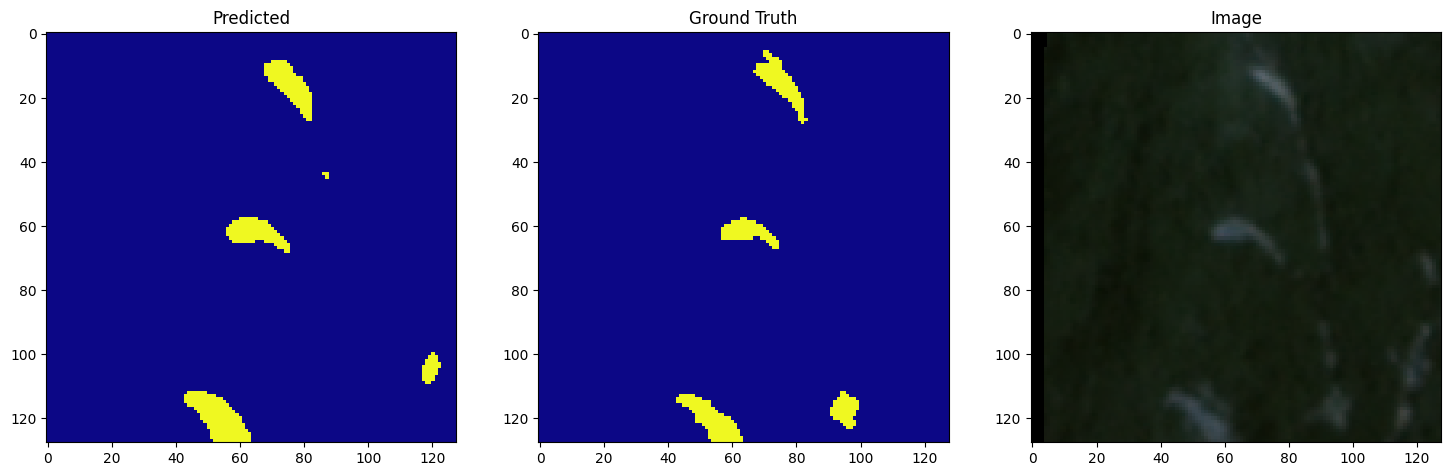

In [56]:
n = 10  # sample number
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
im1 = ax[0].imshow(
    val_preds[n, :, :, :3].transpose((0, 1, 2)), vmin=0, vmax=1.0, cmap="plasma"
)
im2 = ax[1].imshow(y_test[n, :, :, 0], cmap="plasma")

ax[2].imshow(X_test[n, :, :, :3].transpose((0, 1, 2)))

ax[0].ticklabel_format(useOffset=False, style="plain")
ax[1].ticklabel_format(useOffset=False, style="plain")
ax[2].ticklabel_format(useOffset=False, style="plain")

ax[0].set_title("Predicted")
ax[1].set_title("Ground Truth")
ax[2].set_title("Image")

# fig.colorbar(im1, ax=ax[0])
# fig.colorbar(im2, ax=ax[1])